# Random Forest Final Model - Trinidad Head, USA

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import sys
sys.path.append('../../')
import config as cfg

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [2]:
site = cfg.site
site_name = cfg.site_dict[site]
assert site == 'THD', 'This script is only for Trinidad Head, USA. The site can be changed in the config file.'

compound = cfg.compound

print(f"Creating a random forest model for \033[1m{site_name}\033[0;0m.")

Creating a random forest model for Trinidad Head, USA.


### Loading & Initialising Data

In [3]:
data = pd.read_csv(data_path/f'for_model_pca_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,flag
10489,2012-06-07 03:00:00,3.997137,-2.829640,-2.597070,3.045724,-5.889827,-2.467593,-2.707566,-2.976285,-1.781555,...,-0.340515,-0.735281,0.372664,-2.078053,-0.273874,-0.527699,-0.505248,0.396931,-0.034815,1.0
203,2000-03-26 05:00:00,-0.952063,-7.510522,3.578782,-2.388240,0.733748,-1.466897,2.047135,3.421745,-1.558468,...,-3.564392,-3.897435,-4.143080,3.788249,-4.183010,1.561404,0.295164,-0.872245,3.906923,1.0
3285,2003-06-24 07:00:00,-8.294011,0.732899,3.226317,2.838478,-3.361699,0.515122,0.277023,-1.488815,-0.173153,...,-0.392133,2.049457,0.589835,-0.605191,-0.830131,-0.701980,-0.227461,1.026059,0.929250,1.0
4211,2004-05-05 11:00:00,6.431441,-2.242259,1.675843,-3.282034,3.170083,-3.409829,-2.367449,0.537178,-1.102783,...,0.270943,-1.319279,1.824573,1.636844,0.960969,-0.941686,0.993322,-1.959951,-1.265532,1.0
2987,2003-05-09 19:00:00,-3.981734,3.540414,3.597850,5.355782,0.759679,-1.094620,-0.495699,-1.027289,1.268871,...,0.145787,-0.240643,-3.261984,0.827329,1.051047,-0.760556,0.848627,-2.217071,-1.290217,1.0


In [4]:
train_data = data[(data['time'].dt.year >= 2018) & (data['time'].dt.year <= 2018)]
val_data = data[(data['time'].dt.year >= 2019) & (data['time'].dt.year <= 2019)]
test_data = data[(data['time'].dt.year >= 2020) & (data['time'].dt.year <= 2023)]


print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")


# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2018-01-04 09:00:00 -> 2018-12-31 05:00:00. Length: 421
Val range: 2019-01-01 23:00:00 -> 2019-12-31 13:00:00. Length: 426
Test range: 2020-01-03 19:00:00 -> 2023-09-18 17:00:00. Length: 1549


### Model

In [6]:
# fitting models based on optimal hyperparameters
rf_model = RandomForestClassifier(random_state=42,
                                  n_estimators=100,
                                  max_depth=5,
                                  criterion='gini',
                                  bootstrap=True,
                                  min_samples_split=2,
                                  max_features = 'sqrt',)

rf_model.fit(X_train, y_train)

class_probabilities_val = rf_model.predict_proba(X_val)
class_probabilites_train = rf_model.predict_proba(X_train)

confidence_threshold = cfg.confidence_threshold

y_pred_val = (class_probabilities_val[:, 1] >= confidence_threshold).astype(int)
y_pred_train = (class_probabilites_train[:, 1] >= confidence_threshold).astype(int)


precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)
misclassification_rate_val = 1 - accuracy_score(y_val, y_pred_val)
misclassification_rate_train = 1 - accuracy_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")
print(f"Misclassification Rate on Training Set = {misclassification_rate_train:.3f}")
print(f"Misclassification Rate on Validation Set = {misclassification_rate_val:.3f}")

Precision on Training Set = 0.996
Precision on Validation Set = 0.898
Recall on Training Set = 0.771
Recall on Validation Set = 0.397
F1 Score on Training Set = 0.869
F1 Score on Validation Set = 0.550
Misclassification Rate on Training Set = 0.159
Misclassification Rate on Validation Set = 0.441


In [7]:
# evaluating the model on the test set

class_probabilities_test = rf_model.predict_proba(X_test)

y_pred_test = (class_probabilities_test[:, 1] >= confidence_threshold).astype(int)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
misclassification_rate_test = 1 - accuracy_score(y_test, y_pred_test)

print(f"Precision on Test Set = {precision_test:.3f}")
print(f"Recall on Test Set = {recall_test:.3f}")
print(f"F1 Score on Test Set = {f1_test:.3f}")
print(f"Misclassification Rate on Test Set = {misclassification_rate_test:.3f}")

Precision on Test Set = 0.915
Recall on Test Set = 0.437
F1 Score on Test Set = 0.591
Misclassification Rate on Test Set = 0.412


In [8]:
# saving model
dump(rf_model, data_path/f'rf_model_{site}.joblib')
dump(rf_model, f'../model_files/rf_model_{site}.joblib')

['../model_files/rf_model_THD.joblib']

### Confusion Matrix

Text(0.5, 1.0, 'Trinidad Head, USA')

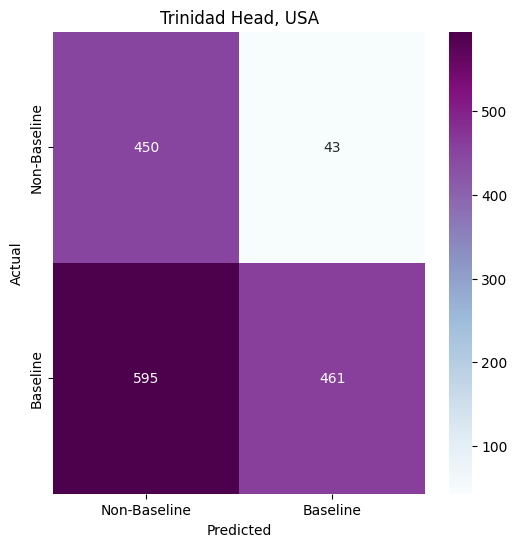

In [9]:
# creating a confusion matrix
conf_matrix = pd.crosstab(y_test, y_pred_test, rownames=['Actual'], colnames=['Predicted'])

conf_matrix.columns = ['Non-Baseline', 'Baseline']
conf_matrix.index = ['Non-Baseline', 'Baseline']

fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu', cbar=True, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

ax.set_title(f'{site_name}')

### Assessing Feature Importance

C:\Users\kirst\AppData\Local\Temp\ipykernel_42916\2727923051.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(feature_importances.index)


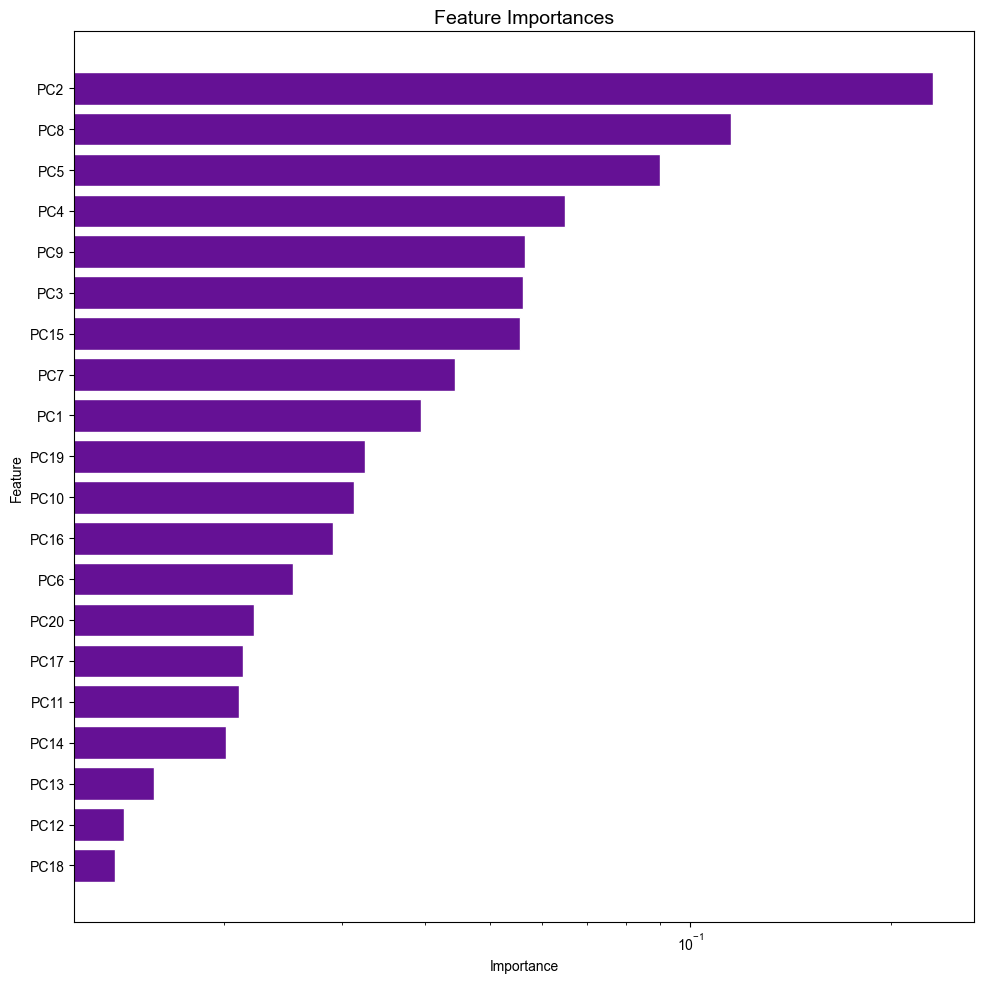

In [10]:
# finding most important features in the model

feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.set_theme(style='ticks', font='Arial')

# sorting feature importances
feature_importances = feature_importances.sort_values('importance', ascending=True)

# bar chart of feature importances
ax.barh(feature_importances.index, feature_importances['importance'], color='#651195')

# making y axis logaritmic
ax.set_xscale('log')

ax.set_ylabel('Feature')
ax.set_xlabel('Importance')
ax.set_title('Feature Importances', fontsize=14)
ax.set_yticklabels(feature_importances.index)

fig.tight_layout()

In [11]:
# identifying the three most important features
top_3_features = feature_importances.sort_values('importance', ascending=False).head(3)
first = top_3_features.index[0]
second = top_3_features.index[1]
third = top_3_features.index[2]

print(f"The three most important features are: \033[1m{first}\033[0;0m, \033[1m{second}\033[0;0m, and \033[1m{third}\033[0;0m.")

The three most important features are: PC2, PC8, and PC5.


In [12]:
# retrieving loadings from model setup
loadings = pd.read_csv(data_path/f'pca_loadings_{compound}_{site}.csv', index_col=0)
loadings

# extracting loadings of top 3 most important PCAs
# based on names of the identified most important PCs
first_pca = loadings[first]
second_pca = loadings[second]
third_pca = loadings[third]

# identifying features with the highest loadings in top 3 PCAs
first_pca = first_pca.abs().sort_values(ascending=False)
second_pca = second_pca.abs().sort_values(ascending=False)
third_pca = third_pca.abs().sort_values(ascending=False)

print(f"Top 5 features in {first}: {first_pca.head(3).index.values}")
print(f"Top 5 features in {second}: {second_pca.head(3).index.values}")
print(f"Top 5 features in {third}: {third_pca.head(3).index.values}")

Top 5 features in PC2: ['v500_15' 'v500_15_past' 'v500_7']
Top 5 features in PC8: ['u500_9' 'u10_5' 'v10_15_past']
Top 5 features in PC5: ['u500_11' 'u500_3_past' 'u500_3']


In [13]:
# identifying what position importance blh is in for PCA2, 12 and 11
print(f"Position of 'blh' in {first}: {first_pca.index.get_loc('blh')}")
print(f"Position of 'blh' in {second}: {second_pca.index.get_loc('blh')}")
print(f"Position of 'blh' in {third}: {third_pca.index.get_loc('blh')}")

Position of 'blh' in PC2: 14
Position of 'blh' in PC8: 63
Position of 'blh' in PC5: 170


Text(0.5, 1.02, 'Feature Importances for PCA Loadings')

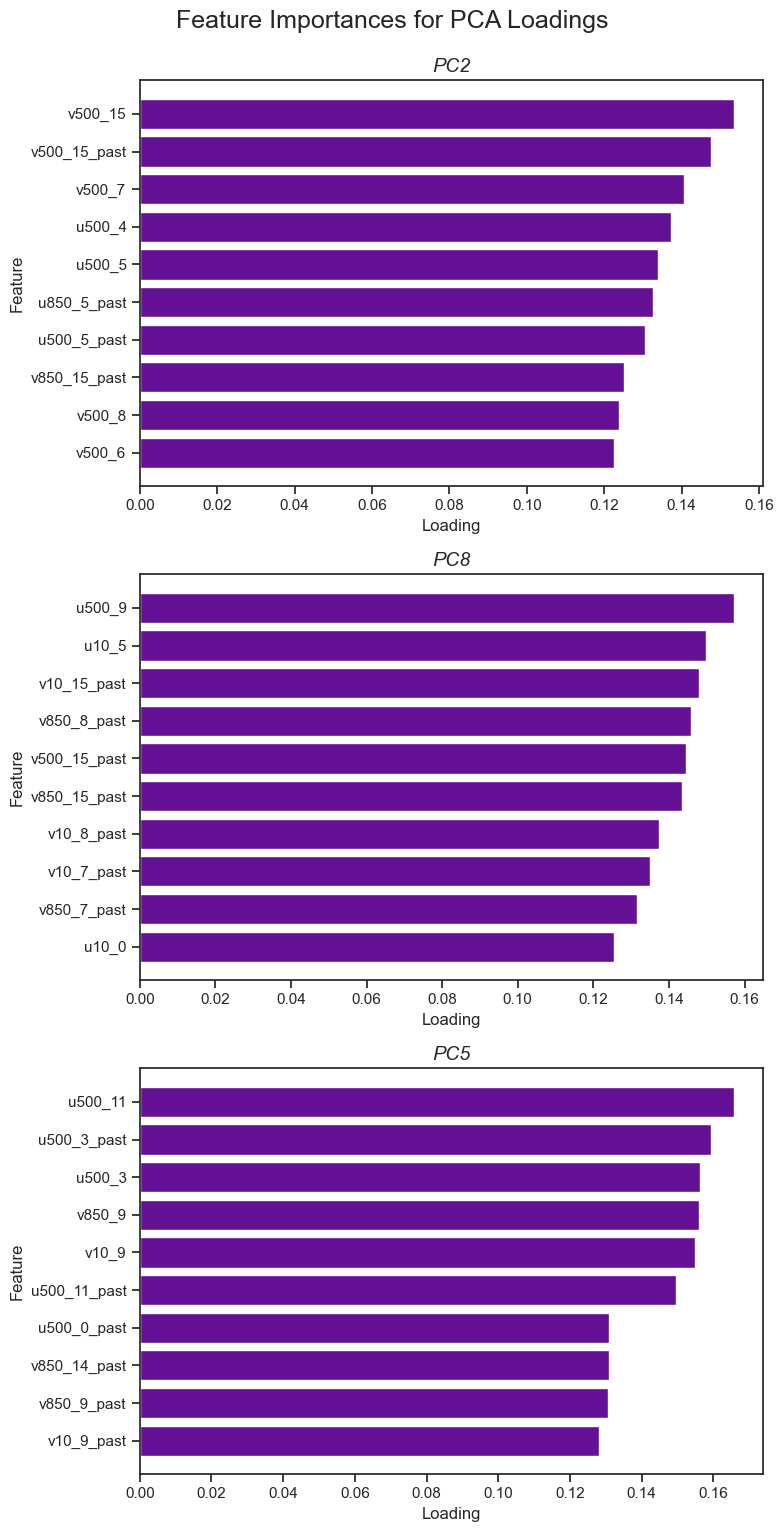

In [14]:
# plotting feature importances for loading of PCA2, 12 and 11
fig, axes = plt.subplots(3,1,figsize=(8, 15))
sns.set_theme(style='ticks', font='Arial')

# filtering feature importances for PCA2 - only including 10 most important features and sorting them
first_pca = first_pca.loc[first_pca.index[:10]].sort_values(ascending=True)
second_pca = second_pca.loc[second_pca.index[:10]].sort_values(ascending=True)
third_pca = third_pca.loc[third_pca.index[:10]].sort_values(ascending=True)

# bar chart of feature importances
axes[0].barh(first_pca.index, first_pca, color='#651195')
axes[1].barh(second_pca.index, second_pca, color='#651195')
axes[2].barh(third_pca.index, third_pca, color='#651195')

# adding titles and labels
axes[0].set_ylabel('Feature')
axes[0].set_xlabel('Loading')
axes[0].set_title(f'{first}', fontsize=14, fontstyle='italic')

axes[1].set_ylabel('Feature')
axes[1].set_xlabel('Loading')
axes[1].set_title(f'{second}', fontsize=14, fontstyle='italic')

axes[2].set_ylabel('Feature')
axes[2].set_xlabel('Loading')
axes[2].set_title(f'{third}', fontsize=14, fontstyle='italic')

fig.tight_layout()
fig.suptitle('Feature Importances for PCA Loadings', fontsize=18, y=1.02)